# Import Librerie

In [87]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler

# Definizione funzioni

In [88]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [89]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/master/synthetic_dataset.csv')    

In [90]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze()

In [91]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [92]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.axvline(x=total*portion, linestyle=":", color="red")
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizazione Serie Temporali Sintentiche

In [93]:
dataset = getRemoteDataset()

In [94]:
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)

<AxesSubplot:xlabel='x', ylabel='y'>

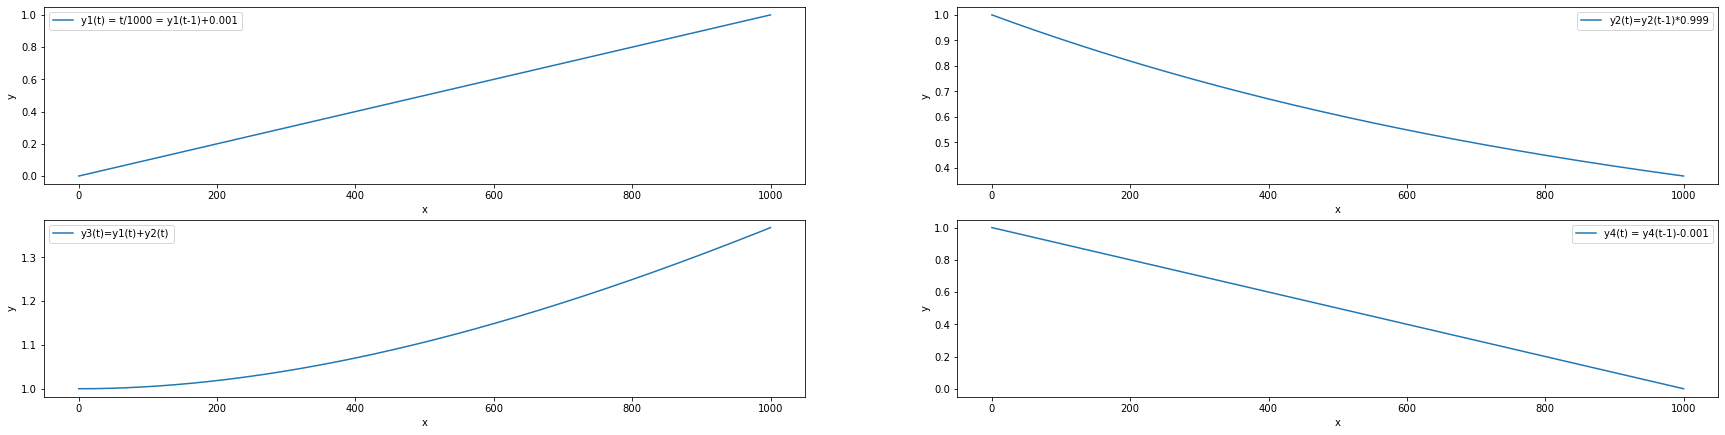

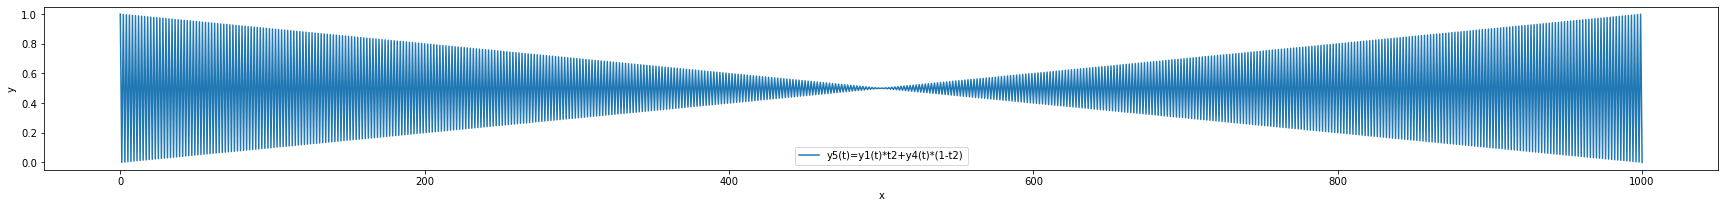

In [95]:
plt.figure(figsize=(30,15))

plt.subplot(4, 2, 1)
series1.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y1(t) = t/1000 = y1(t-1)+0.001")

plt.subplot(4, 2, 2)
series2.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y2(t)=y2(t-1)*0.999")

plt.subplot(4, 2, 3)
series3.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y3(t)=y1(t)+y2(t)")

plt.subplot(4, 2, 4)
series4.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y4(t) = y4(t-1)-0.001")

plt.figure(figsize=(30,3))
series5.plot(kind="line", xlabel="x", ylabel="y", legend=True, label="y5(t)=y1(t)*t2+y4(t)*(1-t2)")

# DatasetManager e Inizializzazione Long Short Term Memory
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il nuemro di feature e il numero di variabili target.

In [96]:
class DatasetManager():
    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, df):
        tempColumns = df.columns
        scaler = MinMaxScaler()
        scalerDf = scaler.fit(df.to_numpy())
        df_scaled = scalerDf.transform(df)
        return pd.DataFrame(df_scaled, columns=tempColumns)

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = sequences
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        tempDf = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)
        self.df = self.__getScaledDataFrame(tempDf)

    def __len__(self):
        return len(self.sequences)

    def __train_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return xCol[0: int(len(self.sequences)*self.portion)], yCol[0: int(len(self.sequences)*self.portion)]
    
    def __test_set__(self):
        xCol = self.df[self.df.columns[0:self.features_sequences]].to_numpy()
        yCol = self.df[self.df.columns[self.features_sequences:]].to_numpy()
        return  xCol[int(self.df['t'].size*self.portion):], yCol[int(self.df['t'].size*self.portion):]


In [97]:
class LSTM_Predictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
        super(LSTM_Predictor, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        hidden_defaults = torch.zeros(self.num_layers, self.seq_len, self.hidden_dim).cuda() if torch.cuda.is_available() else torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
        self.hidden = (hidden_defaults,hidden_defaults)
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = num_layers,
            dropout = .1
        )
        self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        y_pred = self.linear(
            lstm_out.view(self.seq_len, len(sequences), self.hidden_dim)[-1]
        )
        return y_pred

In [98]:
def train_NN_model(model, train_data, train_labels, test_data, test_labels, num_epochs, inference = 10, verbose=True):
    
    if torch.cuda.is_available():
        model.train()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        y_train_pred = model(train_data)
        loss = RMSE_Loss(train_labels, y_train_pred)

        with torch.no_grad():
            y_test_pred = model(test_data[:-inference])
            test_loss = RMSE_Loss(test_labels[:-inference], y_test_pred)
        test_hist[t] = test_loss.item()

        if t % 10==0 and verbose is True:
            print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model.eval(), train_hist, test_hist, y_test_pred, y_train_pred

In [99]:
def executeLSTM(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25, iterations=1):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    x_train, y_train = dataset.__train_set__()
    x_test, y_test = dataset.__test_set__()

    x_train_tensor = torch.tensor(data=x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(data=y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(data=x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(data=y_test, dtype=torch.float32)


    print(''.join(['> ' for i in range(50)]))
    print(f'\n{"EPOCH":<15}{"TRAINING RMSE":<18}{"TESTING RMSE":<18}\n')
    print(''.join(['> ' for i in range(50)]))
    model = LSTM_Predictor(input_dim=1, hidden_dim=128, seq_len=1).to("cpu")
    rmse_TRAIN = []
    rmse_TEST = []
    x_trainDf2 = torch.tensor(data=x_train_tensor, dtype=torch.float32)
    y_trainDf2 = torch.tensor(data=y_train_tensor, dtype=torch.float32)
    x_testDf2 = torch.tensor(data=x_test_tensor, dtype=torch.float32)
    y_testDf2 = torch.tensor(data=y_test_tensor, dtype=torch.float32)

    for i in range(iterations):
        model, train_hist, test_hist, y_pred, y_pred_train, = train_NN_model(model, x_trainDf2, y_trainDf2, x_testDf2, y_testDf2, num_epochs=num_epochs, verbose=False)
        rmse_TEST.append(test_hist[num_epochs-1])
        rmse_TRAIN.append(train_hist[num_epochs-1])
        print(f'{(iterations - i):>3}) {str(num_epochs):<15}{train_hist[num_epochs-1]:<18.3f}{test_hist[num_epochs-1]:<18.3f}')
        
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze()[:-10],
        y_predicted_train=y_pred_train.detach().numpy().flatten(),
        y_predicted_test=y_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_pred_train.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze()[:-10], y_pred.detach().numpy().flatten()),
        rmse_train=rmse_TRAIN,
        rmse_test=rmse_TEST
    )

# Esecuzione Long Short Term Memory

In [100]:
features_length = 1 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 0 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 25
max_iter = 20

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.147             0.142             
 19) 25             0.117             0.224             
 18) 25             0.066             0.038             
 17) 25             0.062             0.076             
 16) 25             0.058             0.092             
 15) 25             0.058             0.099             
 14) 25             0.051             0.073             
 13) 25             0.047             0.057             
 12) 25             0.045             0.080             
 11) 25             0.045             0.087             
 10) 25             0.032             0.035             
  9) 25             0.032             0.056             
  8) 25             0.028             0.015             
  7

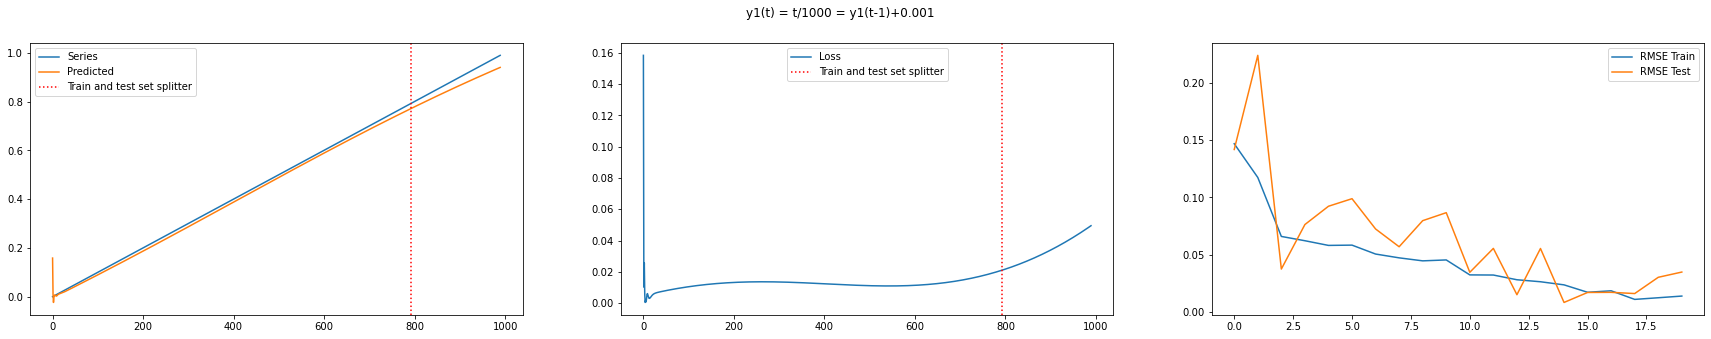

In [101]:
executeLSTM("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.192             0.390             
 19) 25             0.066             0.100             
 18) 25             0.072             0.092             
 17) 25             0.058             0.022             
 16) 25             0.059             0.005             
 15) 25             0.045             0.007             
 14) 25             0.040             0.007             
 13) 25             0.043             0.012             
 12) 25             0.036             0.041             
 11) 25             0.036             0.006             
 10) 25             0.033             0.013             
  9) 25             0.029             0.029             
  8) 25             0.028             0.005             
  7

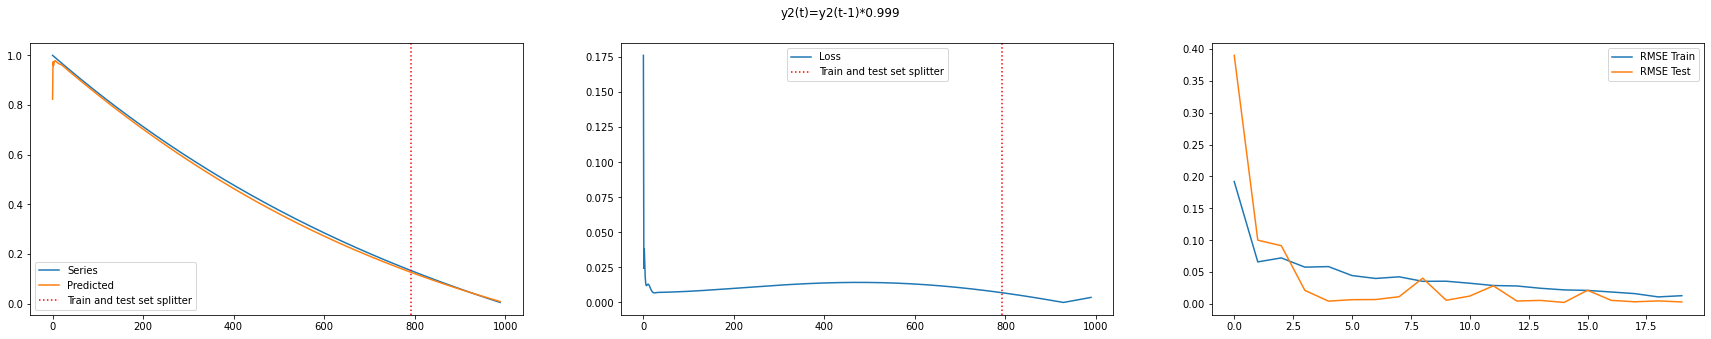

In [106]:
executeLSTM("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.140             0.089             
 19) 25             0.078             0.020             
 18) 25             0.066             0.143             
 17) 25             0.060             0.195             
 16) 25             0.056             0.189             
 15) 25             0.050             0.155             
 14) 25             0.044             0.144             
 13) 25             0.042             0.111             
 12) 25             0.042             0.096             
 11) 25             0.036             0.057             
 10) 25             0.035             0.098             
  9) 25             0.029             0.060             
  8) 25             0.026             0.027             
  7

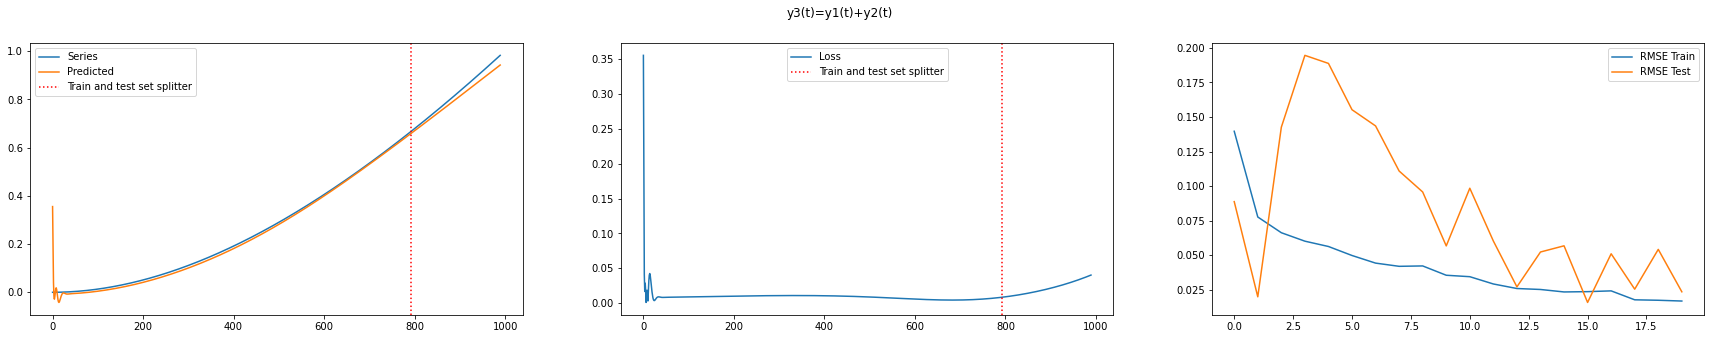

In [107]:
executeLSTM("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.196             0.458             
 19) 25             0.074             0.099             
 18) 25             0.100             0.172             
 17) 25             0.055             0.058             
 16) 25             0.054             0.027             
 15) 25             0.051             0.016             
 14) 25             0.047             0.019             
 13) 25             0.045             0.011             
 12) 25             0.048             0.008             
 11) 25             0.041             0.100             
 10) 25             0.034             0.037             
  9) 25             0.028             0.087             
  8) 25             0.036             0.055             
  7

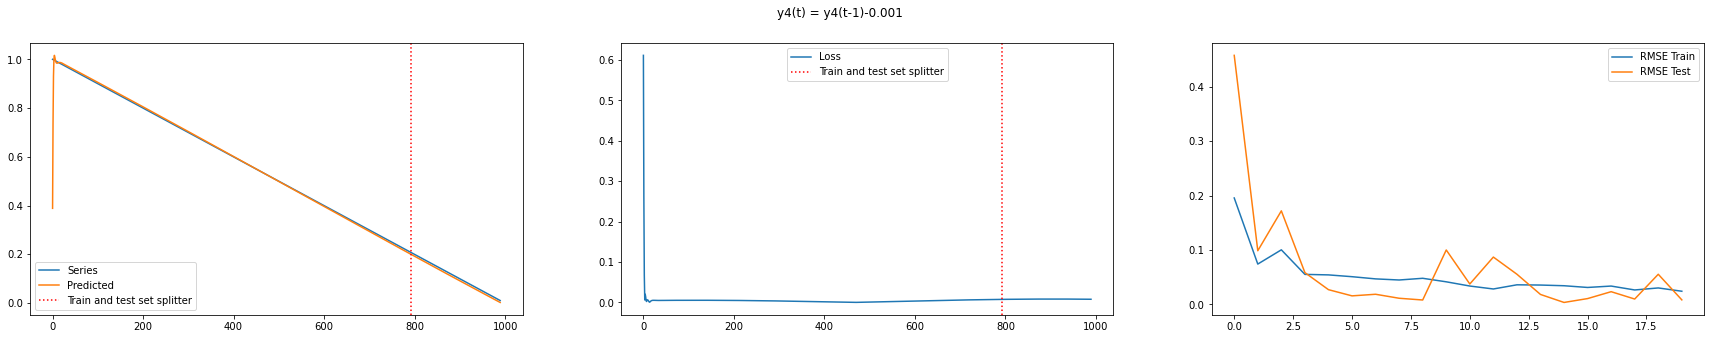

In [108]:
executeLSTM("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

EPOCH          TRAINING RMSE     TESTING RMSE      

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
 20) 25             0.254             0.402             
 19) 25             0.248             0.394             
 18) 25             0.210             0.333             
 17) 25             0.037             0.013             
 16) 25             0.035             0.040             
 15) 25             0.033             0.010             
 14) 25             0.030             0.011             
 13) 25             0.030             0.036             
 12) 25             0.025             0.009             
 11) 25             0.024             0.015             
 10) 25             0.023             0.018             
  9) 25             0.021             0.010             
  8) 25             0.020             0.010             
  7

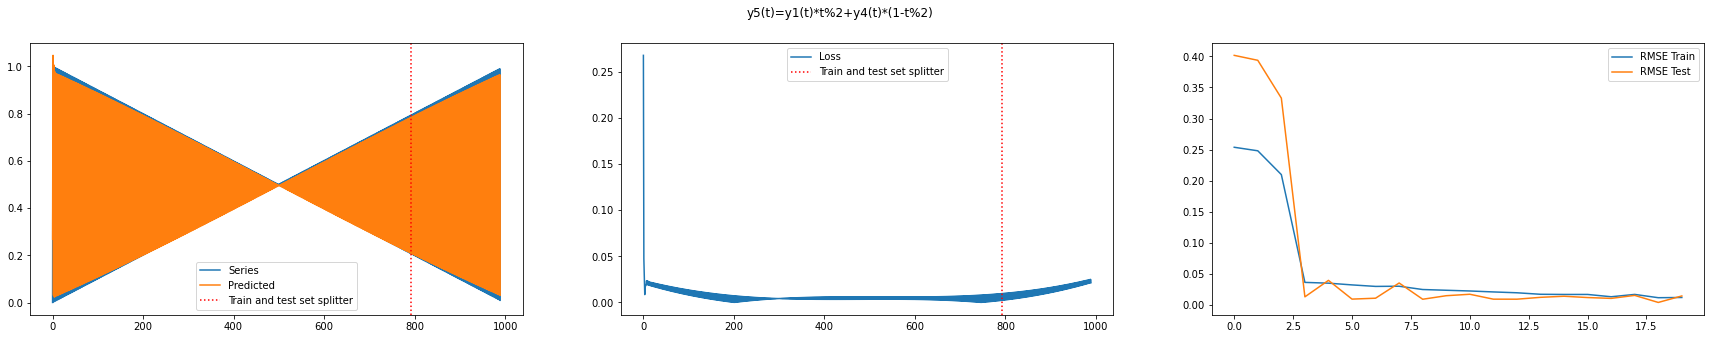

In [109]:
executeLSTM("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs, iterations=max_iter)